## Visualizing results -  SpaCy Geotagger + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of a particular book, and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

The book that we have used for this experiment is the **First Edition, Volume 1, A-B** (year 1771) of the *Encyclopaedia Britannica*, which has 832 pages.
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_subsample.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_144133901' -n 16`

The nls_subsample.txt has the path of this particular book that we are exploring:

`xxx/nls-data-encyclopaediaBritannica/144133901`

And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`

The results file ( [georesolution_en_core_web_lg_EB_144133901](http://localhost:8888/edit/results_NLS/georesolution_en_core_web_lg_EB_144133901) ) is stored in this repository under the *results_NLS* subdirectory. 

Note: We just perfomed this study using all the pages of one boo. But we could run this query using the full EB dataset.


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def display_spacy_entities(result):
    for i in result.keys():
        for k in result[i]:
            html= k["display_doc"]
            if html:
                print(" \n ----- %s: Entities with the Spacy \"%s\" language model  ----- \n" % (k["text_unit id"], k["lang_model"]))
                display(HTML(html))

In [4]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [5]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [6]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = df_max_geolocations.iloc[i]['count'], df_max_geolocations.iloc[i]['Place'] 
        if place_name not in filter_list:
            print(i, place_count,place_name)
            place_label.append(place_name)
            place_freq.append(place_count)
            k = k + 1
        i = i + 1
    return place_label, place_freq

In [7]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq, color = 'green')
    plt.xlabel('Places', fontsize=10)
    plt.ylabel('Frequency of Places', fontsize=5)
    plt.xticks(index, place_label, fontsize=8, rotation=40)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')

### Information about the defoe georesolution query

This query does the following tasks:

- Ingests all the pages from the directory "144133901",  which corresponds to the book "Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * display_doc: HTML string with the name entities detected by spacy for each page
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. In this case, number of pages of this particular book (e.g. 832)
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (e.g. en_core_web_lg)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


Example:
  - archive_filename: /home/tdm/datasets/encyclopaedia-britannica-sample/144133901
  - clean_text: "ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent
    SCIENCES and ARTS are dioefted into " O diflinct Treatifes or Syitems; AND . The
    \irious TECHNIC A LTERMS, <&C. are explained as they occur in the order of the
    Alphabet. ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES. fry a SOCIETY of
    GENTLEMEN in SCOTLAND .... "
  - display_doc:"<div class=\"entities\" style=\"line-height: 2.5; direction: ltr\"\
    >ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent SCIENCES\
    \ and ARTS .... "
  - edition: First edition, 1771, Volume 1, A-B
  - georesolution_page:
    SCOTLAND-rb3:
        - '56'
        - '-4'
  - lang_model: en_core_web_lg
  - model: nls
  - num_text_unit: 832
  - page_filename: alto/188082826.34.xml
  - place: Edinburgh
  - text_unit: page
  - text_unit id: Page9
  - type_distribution: book
  - year: 1771



In [8]:
results=read_query_results('georesolution_en_core_web_lg_EB_144133901')

In [9]:
#display_spacy_entities(results)

In [10]:
df_total= geresolution_dataframe(results)

In [11]:
df_total[["Place"]].count()

Place    1568
dtype: int64

In [12]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
.(Ethiopia,1,1,1
ABERDEEN,1,1,1
ABU SAN,1,1,1
ACAPULCO,1,1,1
ANCHORAGE,1,1,1
ANDALUSIA,1,1,1
ANDAMAN,1,1,1
ANDES,1,1,1
ANEGADA,1,1,1


In [13]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page13,5,5,5
Page14,3,3,3
Page15,16,16,16
Page16,17,17,17
Page17,19,19,19
Page18,15,15,15
Page19,14,14,14
Page21,9,9,9
Page22,10,10,10


In [14]:
df_total.groupby(["Latitude", "Longitude"]).count()

Place  Page
Latitude  Longitude              
-1.25     -78.25          1     1
-10       -55             7     7
          -75.25          4     4
          70              1     1
-12.04318 -77.02824       1     1
-12.5     18.5            2     2
-14.56667 35.71667        1     1
-14.60485 -57.65625       5     5
-16.44972 -39.06472       1     1
-17.98333 20.78333        1     1
-18.50536 29.73176        1     1
-20.37778 -43.41611       1     1
-23.33333 -58             1     1
-26.13957 152.74833       1     1
-29.48333 30.33333        1     1
-3.2607   29.6049         1     1
-30       -71             1     1
-31.95224 115.8614        1     1
-32.75    -70.46667       1     1
-34       -64             2     2
-36.92621 -63.29354       1     1
-38.54043 143.97636       1     1
-42.21225 -73.80615       1     1
-49       -70             1     1
-6.78833  107.48472       1     1
-9.6361   119.5582        1     1
10.03311  78.16505        1     1
10.06069  -2.50192        2     2
10.83333  -10.66667      10    10
10.95     106.7           1     1
...                     ...   ...
55.86515  -4.25763        1     1
55.95206  -3.19648        5     5
56        -4             26    26
          10              3     3
56.05     -5.11667        1     1
56.46913  -2.97489        1     1
57.14369  -2.09814        3     3
59.32938  18.06871        1     1
59.51139  25.945          1     1
6.12874   1.22154         3     3
6.15      0.11667         1     1
6.33333   38.45           1     1
6.53774   3.3522          1     1
6.75422   -58.20407       1     1
6.78234   -75.56191       1     1
60        100             3     3
60.10867  -113.64258      4     4
61.1433   54.36585        1     1
61.21806  -149.90028      2     2
62        10              4     4
          15              6     6
64        26              1     1
65        -18             1     1
7.1881    21.09375       31    31
7.44483   4.11346         1     1
7.75      80.75           1     1
8.5       -11.5           1     1
9         39.5            8     8
9.45472   6.76377         1     1
9.8723    -74.31032       1     1

[611 rows x 2 columns]

In [15]:
df_max_geolocations= df_total[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     


df_max_geolocations.head(15)

,Place,count
208,France,71
199,Europe,57
113,Britain,49
215,Germany,45
36,America,42
258,Italy,38
27,Africa,31
194,England,31
289,London,29
387,Rome,26


In [16]:
#Getting the 15 places (and their frequencies) most mentioned - filtering some elements
filter_list=['E. long.', 'earth']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)

0 71 France
1 57 Europe
2 49 Britain
3 45 Germany
4 42 America
5 38 Italy
6 31 Africa
7 31 England
8 29 London
9 26 Rome
10 25 Scotland
12 21 Spain
14 17 Egypt
15 14 Asia
16 13 Paris


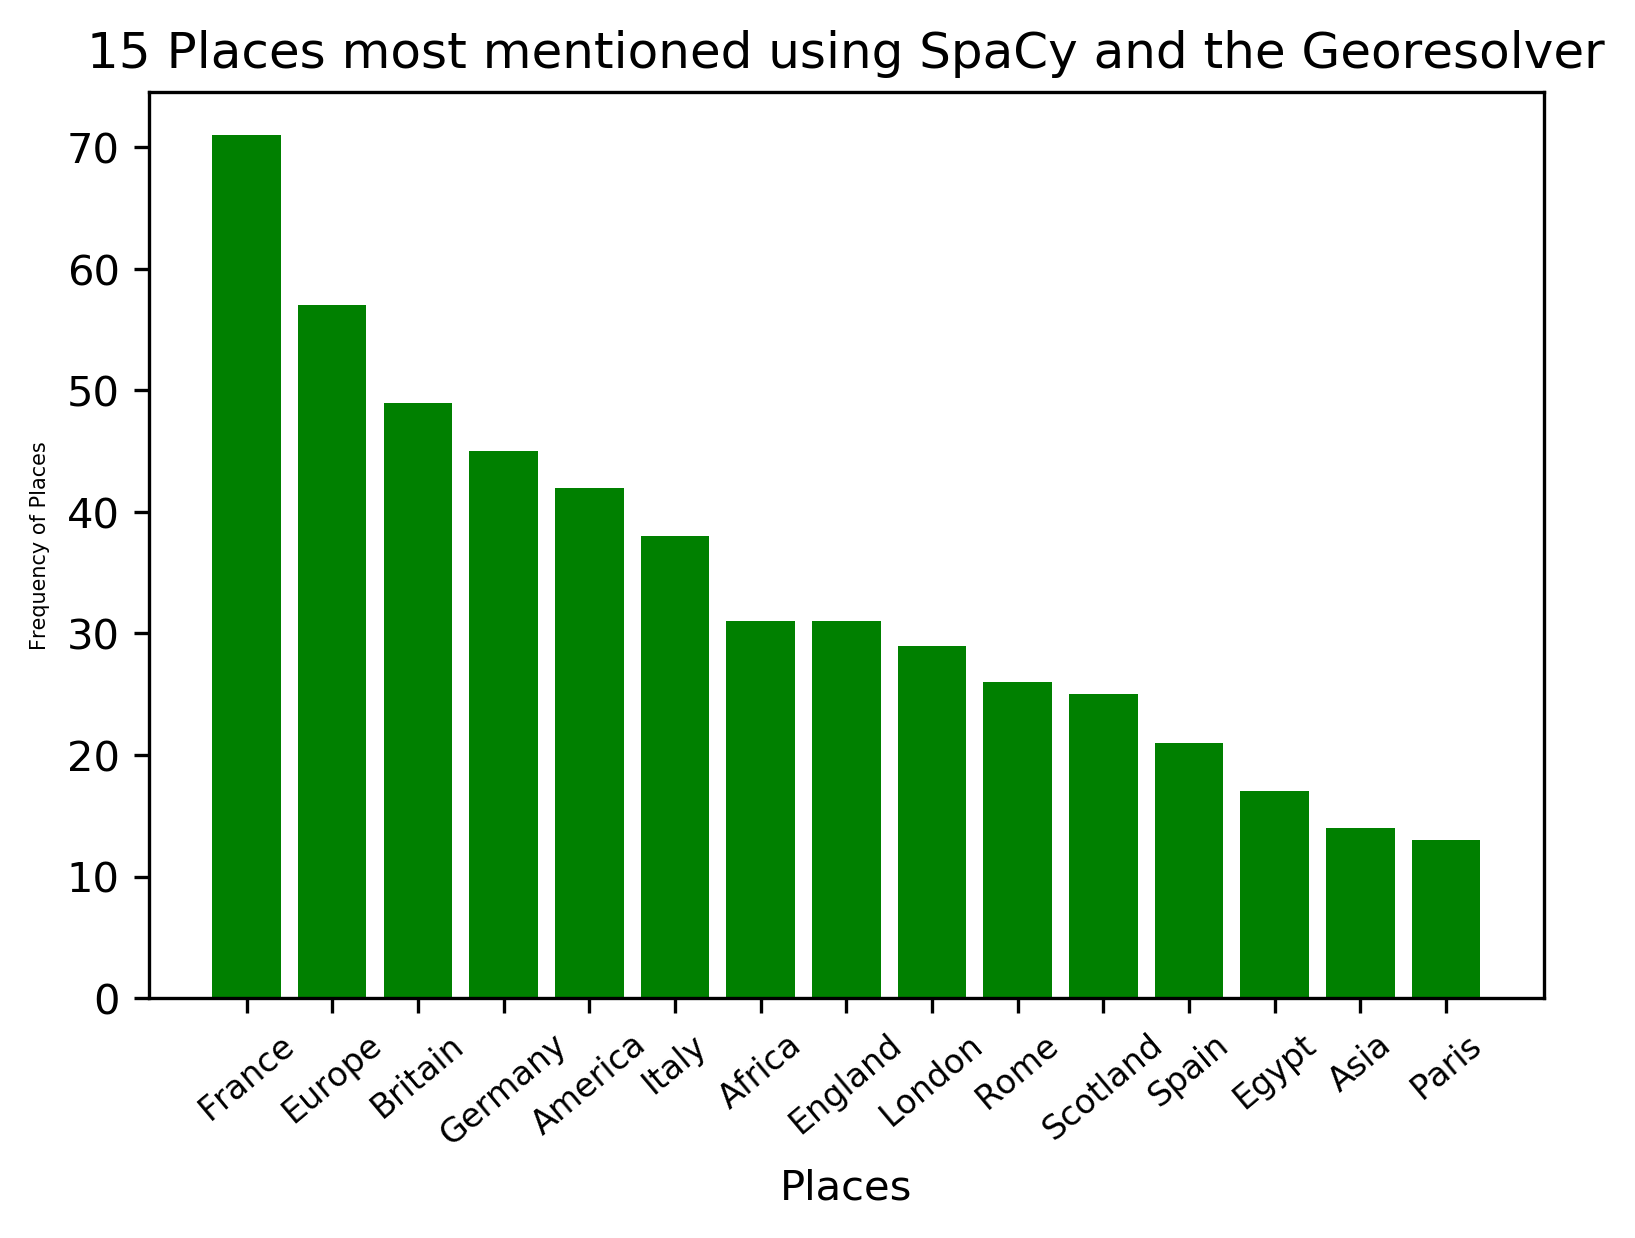

In [17]:
#Visualizing the 15 places in a Bar plot
mpl.rcParams['figure.dpi']=300
plot_bar_places(place_label, place_freq)

In [18]:
df_total.sum()

Latitude     5643.9522118.3807836.4884728.750545643.1467542...
Longitude    -4-103.44575-65.95739-79.7667-82.5001-4-71.457...
Place        SCOTLANDCalmetCarolinaEdenFloridaScotlandPembr...
Page         Page9Page13Page13Page13Page13Page13Page14Page1...
dtype: object